In [1]:
import sklearn.metrics as skm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import time
import importlib

In [2]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.device_count())
# choose GPU
torch.cuda.set_device(2)
print(torch.cuda.current_device())

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

True
4
2
cuda


In [3]:
num_clusters = 6

In [4]:
data_dir = './data/neuropixels'

In [5]:
%%time

# The rows are neuron ids, the columns are trial ids. Each entry is a 2 sec spike train time series. The time resolution is 0.1 ms.
df_ = pd.read_json(data_dir+'/raw_data/session798911424_spikes_mar24_2022.json', convert_axes=False, convert_dates=False)
data = df_.iloc[:, 0].values
neuron_ids = df_.index.values
data = pd.DataFrame({neuron_ids[j]: data[j] for j in range(neuron_ids.size)}).T.values
assert data.ndim == 2

# The rows are neuron ids corresponding to the spike train time series table above. The location of the neuron is under column 'probe_description' or 'ecephys_structure_acronym'.
dfn = pd.read_json(data_dir+'/raw_data/session798911424_neurons_apr21_2022.json', convert_axes=False, convert_dates=False)
dfn = dfn['probe_description'].to_dict()
brain_regions, neuron_brain_regions = np.unique([dfn[nid] for nid in neuron_ids], return_inverse=True)
print(brain_regions, neuron_brain_regions)
assert neuron_brain_regions.ndim == 1
domain_clusters = neuron_brain_regions

assert data.shape[0] == domain_clusters.size

data.shape, domain_clusters

['probeA' 'probeB' 'probeC' 'probeD' 'probeE' 'probeF'] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]
CPU times: user 55.6 s, sys: 11.5 s, total: 1

((443, 20000),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 

In [6]:
# number of neurons (to be clustered)
n = data.shape[0]

In [7]:
%%time

import timeseries_dependency_scores as tds
importlib.reload(tds)

# it can be expensive to compute mutual information between every pair of timeseries (441 in this case), which is required for evaluating the clusters, so it's easier to just load it from the data directory
# note that this metric is completely independent in its formulation from the information objective of mutual information for clustering
# this is used only for the purpose for evaluation of clusters from different methods, not for optimizing clusters 
fresh_compute = True

if fresh_compute:
    mi_scores = tds.TimeseriesDependencyScores(metric='mid', num_cores=111, normalize=True).compute_dependency_scores(time_series_data=data)
    np.save(data_dir+'/mi_scores', mi_scores)
else:
    mi_scores = np.load(data_dir+'/mi_scores.npy')

443 20000
...........................................................................................................................................................................................................................................................................................................................................................................................................................................................***********************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************
CPU times: user 19.2 s, sys: 42.6 s, total: 1min 1s
Wall time: 1min 25s


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


def plot_mi_wrt_clusters(mi, c, font_size=11):

    unique_c, sizes_c = np.unique(c, return_counts=True)
    sort_idx = sizes_c.argsort()
    unique_c = unique_c[sort_idx]
    sizes_c = sizes_c[sort_idx]
    sort_idx = None

    mi_c = np.zeros((unique_c.size, unique_c.size))
    for i, c_i in enumerate(unique_c):
        idx_i = (c == c_i)
        for j, c_j in enumerate(unique_c):
            idx_j = (c == c_j)
            mi_c[i,j] = mi[idx_i, :][:, idx_j].mean()

    diag_idx = np.eye(unique_c.size, dtype=bool)

    sizes_c_matrix = np.outer(sizes_c, sizes_c)

    intra_cluster_score = np.nansum(mi_c[diag_idx]*sizes_c_matrix[diag_idx])/sizes_c_matrix[diag_idx].sum()
    inter_cluster_score = np.nansum(mi_c[~diag_idx]*sizes_c_matrix[~diag_idx])/sizes_c_matrix[~diag_idx].sum()

    if sizes_c.size < 8:
        plt.close()
        ax = sns.heatmap(
            mi_c,
            vmax=min(1.0, mi_c.max()),
            annot=True,
            fmt=".4f",
            cmap="YlGnBu",
        )
        ax.set_xticklabels(sizes_c, fontsize=font_size)
        ax.set_yticklabels(sizes_c, fontsize=font_size)
        ax.set_xlabel('Clusters in the order of sizes', fontsize=font_size)
        ax.set_ylabel('Clusters in the order of sizes', fontsize=font_size)
        plt.title(f'NMI: IntraCluster={round(intra_cluster_score, 6)}, InterCluster{round(inter_cluster_score, 6)}', fontsize=font_size)
        plt.show()
    else:
        plt.close()
        plt.imshow(mi_c, vmax=min(1.0, mi_c.max()))
        plt.rcParams.update({'font.size': font_size})
        plt.xticks(np.arange(sizes_c.size, dtype=np.int), sizes_c, fontsize=font_size)
        plt.yticks(np.arange(sizes_c.size, dtype=np.int), sizes_c, fontsize=font_size)
        plt.colorbar()
        plt.title(f'NMI: IntraCluster={round(intra_cluster_score, 6)}, InterCluster={round(inter_cluster_score, 6)}')
        plt.show()

In [9]:
plt.rcParams['figure.dpi'] = 80

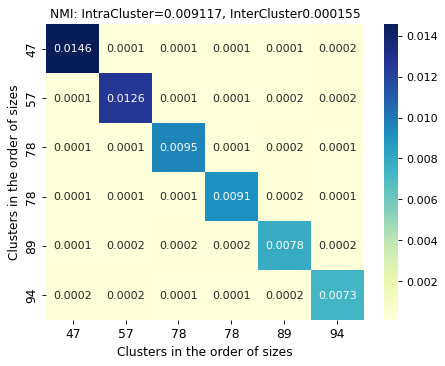

In [10]:
# independent evaluation of clusters in terms of pairwise mutual information between timeseries intra- and inter-cluster.
plot_mi_wrt_clusters(mi_scores, neuron_brain_regions)

# kNN clustering

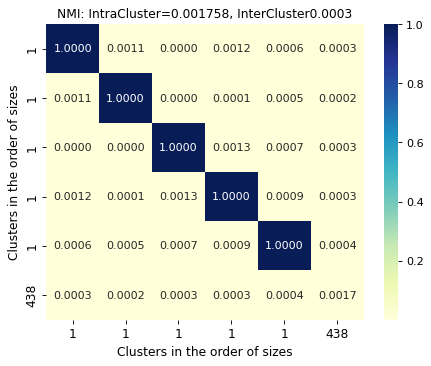

CPU times: user 11min 31s, sys: 3min 52s, total: 15min 23s
Wall time: 6.82 s


In [11]:
%%time

import clustering_evaluator as ce
importlib.reload(ce)

ce_obj = ce.ClusteringEvaluator(num_clusters=num_clusters, seed=0)
kmeans_cluster_labels = ce_obj.cluster_labels_optimize(data=data, cluster_algo='kmeans')

# independent evaluation of clusters in terms of pairwise mutual information between timeseries intra- and inter-cluster.
plot_mi_wrt_clusters(mi_scores, kmeans_cluster_labels)

# Spectral clustering

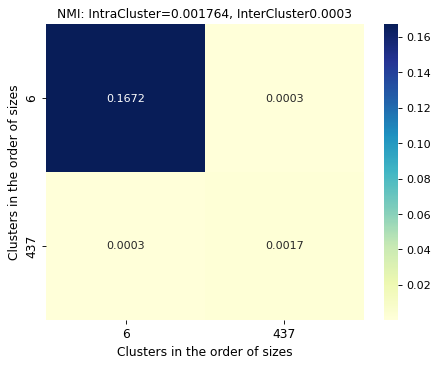

CPU times: user 4.41 s, sys: 3.92 s, total: 8.33 s
Wall time: 288 ms


In [12]:
%%time

import clustering_evaluator as ce
importlib.reload(ce)

ce_obj = ce.ClusteringEvaluator(num_clusters=num_clusters, seed=0)
spectral_cluster_labels = ce_obj.cluster_labels_optimize(data=data, cluster_algo='spectral')

# independent evaluation of clusters in terms of pairwise mutual information between timeseries intra- and inter-cluster.
plot_mi_wrt_clusters(mi_scores, spectral_cluster_labels)

# ITC clustering via kNN (using the mutual information objective)

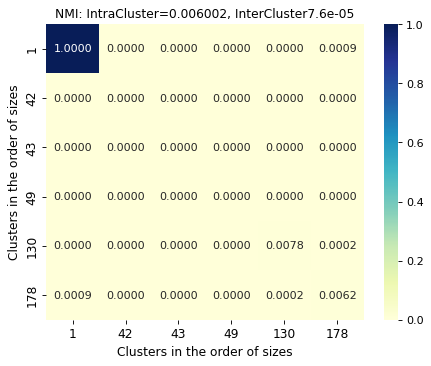

In [13]:
import clustering_evaluator as ce
importlib.reload(ce)

ce_obj = ce.ClusteringEvaluator(num_clusters=num_clusters, seed=0)
sampler = np.random.RandomState(seed=0)
itc_knn_cluster_labels = ce_obj.cluster_labels_optimize(cluster_algo='itc_knn',
    data=data+1e-100*sampler.rand(data.shape[0], data.shape[1])
)

# independent evaluation of clusters in terms of pairwise mutual information between timeseries intra- and inter-cluster.
plot_mi_wrt_clusters(mi_scores, itc_knn_cluster_labels)

# ITC clustering via minimum spanning tree (using the mutual information objective)

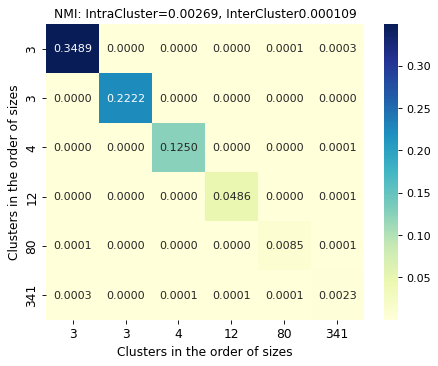

CPU times: user 2.06 s, sys: 1.41 s, total: 3.47 s
Wall time: 599 ms


In [14]:
%%time

import clustering_evaluator as ce
importlib.reload(ce)

ce_obj = ce.ClusteringEvaluator(num_clusters=num_clusters, seed=0)
sampler = np.random.RandomState(seed=0)
itc_mst_cluster_labels = ce_obj.cluster_labels_optimize(cluster_algo='itc_mst',
    data=data+1e-10*sampler.rand(data.shape[0], data.shape[1]),
)

# independent evaluation of clusters in terms of pairwise mutual information between timeseries intra- and inter-cluster.
plot_mi_wrt_clusters(mi_scores, itc_mst_cluster_labels)

# Our ITC-DM approach with LSTMs

....................................................................................................Cluster Sizes [220 223]
....................................................................................................Cluster Sizes [220 112 111]
....................................................................................................Cluster Sizes [ 23 112 111 197]
....................................................................................................Cluster Sizes [ 23 112 111  19 178]
....................................................................................................Cluster Sizes [ 23 112 111  19  76 102]
........................................

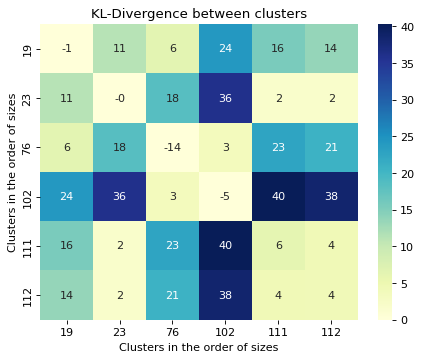

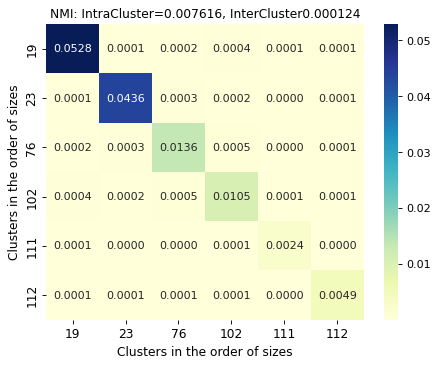

CPU times: user 1min 23s, sys: 5.37 s, total: 1min 28s
Wall time: 1min 24s


In [17]:
%%time

import info_theoretic_kl_div_clustering as itdvo
importlib.reload(itdvo)

itdvo_obj = itdvo.NeuralKLDivClustering(seed=0, debug=False)

cluster_labels_itc_dv_lstm = itdvo_obj.optimize_multiple_clusters_maximize_kl_div_greedy(
    # number of steps should be small when using recurrent models even with LSTM     
    X_org=data.reshape(data.shape[0], 10, -1),
    num_layers=3,
    hidden_size=128,
    num_clusters=6,
    nn='lstm',
    device=device,
)

# this is used for manual tuning of some of the hyperparameters such as number of layers, number of hidden units, etc.
# results for only the final (manual tuned) configuration are considered here.
# there is a separate notenbook for analyzing sensitivity of the results
# simple lighterweight architecture to estimate KL-divergence relative to the one used for optimization     
# transformers are preferred for evaluation for their robustness     
# for transformers, it is fine to process a timeseries as many steps (100 here)
_, _ = itdvo_obj.estimate_kl_div_btw_clusters(
     X=data.reshape(data.shape[0], 100, -1),
     c=cluster_labels_itc_dv_lstm,
     num_layers=2,
     hidden_size=32,
     device=device,
     nn='transformer',
)

# independent evaluation of clusters in terms of pairwise mutual information between timeseries intra- and inter-cluster.
plot_mi_wrt_clusters(mi_scores, cluster_labels_itc_dv_lstm)

# Our ITC-DM approach with Transformers

....................................................................................................Cluster Sizes [111 332]
....................................................................................................Cluster Sizes [111 166 166]
....................................................................................................Cluster Sizes [111  79 166  87]
....................................................................................................Cluster Sizes [111  79  86  87  80]
....................................................................................................Cluster Sizes [64 79 86 87 80 47]
...................................................................

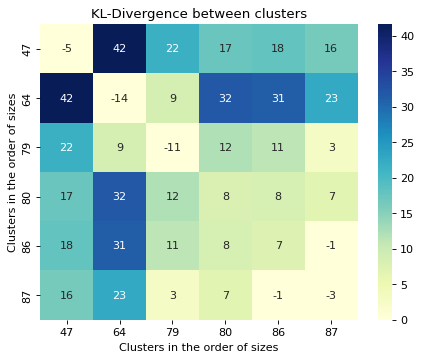

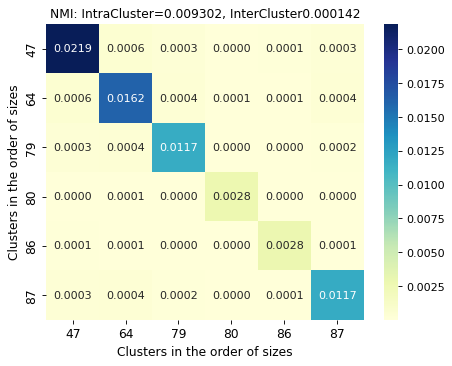

CPU times: user 3min 38s, sys: 17.8 s, total: 3min 56s
Wall time: 3min 44s


In [18]:
%%time

import info_theoretic_kl_div_clustering as itdvo
importlib.reload(itdvo)

itdvo_obj = itdvo.NeuralKLDivClustering(seed=0, debug=False)

cluster_labels_itc_dv_transformer = itdvo_obj.optimize_multiple_clusters_maximize_kl_div_greedy(
# for transformers, it is fine to process a timeseries as many steps (100 here)
    X_org=data.reshape(data.shape[0], 100, -1),
    num_layers=3,
    hidden_size=128,
    num_clusters=6,
    device=device,
    nn='transformer',
)

# this is used for manual tuning of some of the hyperparameters such as number of layers, number of hidden units, etc.
# results for only the final (manual tuned) configuration are considered here.
# there is a separate notenbook for analyzing sensitivity of the results
# simple lighterweight architecture to estimate KL-divergence relative to the one used for optimization     
# transformers are preferred for evaluation for their robustness     
# for transformers, it is fine to process a timeseries as many steps (100 here)
_, _ = itdvo_obj.estimate_kl_div_btw_clusters(
     X=data.reshape(data.shape[0], 100, -1),
     c=cluster_labels_itc_dv_transformer,
     num_layers=2,
     hidden_size=32,
     device=device,
     nn='transformer',
)

# independent evaluation of clusters in terms of pairwise mutual information between timeseries intra- and inter-cluster.
plot_mi_wrt_clusters(mi_scores, cluster_labels_itc_dv_transformer)